<a href="https://colab.research.google.com/github/KatjaGerasimova/Machine_Learning/blob/main/HW_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install stop-words pymorphy2

In [3]:
!pip install nltk

In [7]:
!pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32896 sha256=ce7bf268fb2f13b90decd80f98ca4f2c4edef85efad590c2f4839ec265dc4706
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("punkt")

from string import punctuation
from stop_words import get_stop_words
# from pymorphy2 import MorphAnalyzer

import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [112]:
max_words = 1000
max_len = 10
num_classes = 1

epochs = 15
batch_size = 512
print_batch_n = 100

In [113]:
train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

In [114]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [115]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [116]:
X_train, X_valid = train_test_split(train_df, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape

((23971, 3), (7991, 3))

In [117]:
X_train.label.value_counts()

0    22288
1     1683
Name: label, dtype: int64

In [118]:
X_valid.label.value_counts()

0    7432
1     559
Name: label, dtype: int64

In [119]:
sw = set(get_stop_words("en"))
# sw

In [120]:
puncts = set(punctuation)
# puncts

In [121]:
# morpher = MorphAnalyzer() # это для русского
morpher = WordNetLemmatizer()
morpher.lemmatize('dogs')

'dog'

In [122]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub("не\s", "не", txt)
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [123]:
# train_df.tweet.iloc[:1].values

In [124]:
# train_df.tweet.iloc[:1].apply(preprocess_text).values

In [125]:
from tqdm import tqdm
tqdm.pandas()

X_train.tweet = X_train.tweet.progress_apply(preprocess_text)
X_valid.tweet = X_valid.tweet.progress_apply(preprocess_text)

100%|██████████| 7991/7991 [00:00<00:00, 18378.85it/s]


In [126]:
train_corpus = " ".join(X_train.tweet)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:5]

['weekend', 'world', 'really', 'going', 'bonkers']

In [127]:
# Отфильтруем данные и соберём в корпус N наиболее частых токенов
tokens_filtered = [word for word in tokens if word.isalnum()]

In [128]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

999

In [129]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'u', 'happy', 'amp', 'just', 'will', 'time', 'life']

In [130]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [131]:
def text_to_sequence(text, maxlen):

    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()] # проверка чтобы токен был либо буквенный либо символьный
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))

    return result[-maxlen:] + padding

In [132]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_valid.tweet])

x_train.shape, x_val.shape

CPU times: user 3.69 s, sys: 12 ms, total: 3.7 s
Wall time: 3.73 s


((23971, 10), (7991, 10))

In [133]:
train_df.tweet.iloc[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [134]:
x_train[0]

array([35,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [135]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=64, out_channel=64, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x) # B, L, E
        #                       B  E  L
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [136]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() # если индексы инты то делать лучше лонг - иначе может сломаться вдруг -
        # так как на инт меньше памяти выделяется на каждое значение и может переполниться
        self.target = torch.from_numpy(target).long() # какие то ф-и потерь на интах не считается - а только на лонгах
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [137]:
train_dataset = DataWrapper(x_train, X_train.label.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, X_valid.label.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [138]:
train_loader.sampler

In [139]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [140]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [141]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(1000, 64)
  (conv_1): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=64, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)
Parameters: 86721


In [142]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # засовываем все параметры - они пока необученные
criterion = nn.BCELoss() # класс у нас 1 - поэтому бинарная кросс энтропия тут справляется

In [143]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения (переводим модель в валидацию)
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/15]. Step [47/47]. Loss: 0.156. Acc: 0.912. Test loss: 0.325. Test acc: 0.930
Epoch [2/15]. Step [47/47]. Loss: 0.176. Acc: 0.935. Test loss: 0.441. Test acc: 0.941
Epoch [3/15]. Step [47/47]. Loss: 0.143. Acc: 0.946. Test loss: 0.041. Test acc: 0.943
Epoch [4/15]. Step [47/47]. Loss: 0.099. Acc: 0.955. Test loss: 0.280. Test acc: 0.946
Epoch [5/15]. Step [47/47]. Loss: 0.090. Acc: 0.962. Test loss: 0.001. Test acc: 0.945
Epoch [6/15]. Step [47/47]. Loss: 0.056. Acc: 0.967. Test loss: 0.040. Test acc: 0.942
Epoch [7/15]. Step [47/47]. Loss: 0.103. Acc: 0.973. Test loss: 0.268. Test acc: 0.943
Epoch [8/15]. Step [47/47]. Loss: 0.054. Acc: 0.978. Test loss: 0.284. Test acc: 0.942
Epoch [9/15]. Step [47/47]. Loss: 0.047. Acc: 0.983. Test loss: 0.247. Test acc: 0.941
Epoch [10/15]. Step [47/47]. Loss: 0.045. Acc: 0.986. Test loss: 0.000. Test acc: 0.935
Epoch [11/15]. Step [47/47]. Loss: 0.048. Acc: 0.987. Test loss: 0.001. Test acc: 0.930
Epoch [12/15]. Step [47/47]. Loss: 0.041.

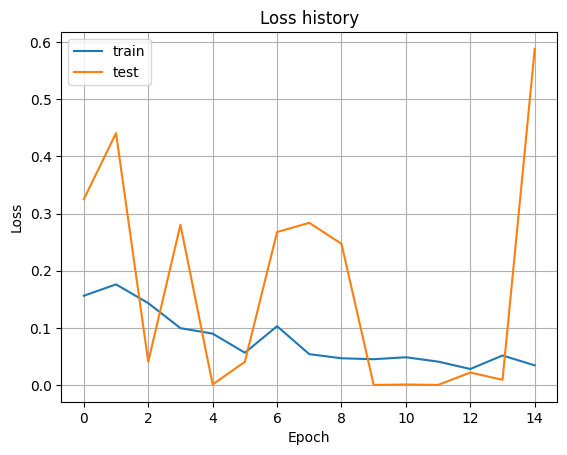

In [144]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

Результат для max_len=20, max_words=2000

Epoch [1/15]. Step [47/47]. Loss: 0.187. Acc: 0.930. Test loss: 0.056. Test acc: 0.930

Epoch [2/15]. Step [47/47]. Loss: 0.158. Acc: 0.938. Test loss: 0.163. Test acc: 0.948

Epoch [3/15]. Step [47/47]. Loss: 0.108. Acc: 0.960. Test loss: 0.007. Test acc: 0.950

Epoch [4/15]. Step [47/47]. Loss: 0.088. Acc: 0.971. Test loss: 0.022. Test acc: 0.942

Epoch [5/15]. Step [47/47]. Loss: 0.066. Acc: 0.979. Test loss: 0.014. Test acc: 0.948

Epoch [6/15]. Step [47/47]. Loss: 0.047. Acc: 0.983. Test loss: 0.000. Test acc: 0.942

Epoch [7/15]. Step [47/47]. Loss: 0.032. Acc: 0.989. Test loss: 0.053. Test acc: 0.942

Epoch [8/15]. Step [47/47]. Loss: 0.022. Acc: 0.991. Test loss: 0.703. Test acc: 0.943

Epoch [9/15]. Step [47/47]. Loss: 0.032. Acc: 0.994. Test loss: 0.000. Test acc: 0.946

Epoch [10/15]. Step [47/47]. Loss: 0.017. Acc: 0.995. Test loss: 0.030. Test acc: 0.943

Epoch [11/15]. Step [47/47]. Loss: 0.010. Acc: 0.996. Test loss: 0.304. Test acc: 0.941

Epoch [12/15]. Step [47/47]. Loss: 0.041. Acc: 0.996. Test loss: 0.000. Test acc: 0.945

Epoch [13/15]. Step [47/47]. Loss: 0.004. Acc: 0.995. Test loss: 1.517. Test acc: 0.947

Epoch [14/15]. Step [47/47]. Loss: 0.024. Acc: 0.997. Test loss: 14.310. Test acc: 0.939

Epoch [15/15]. Step [47/47]. Loss: 0.009. Acc: 0.996. Test loss: 0.000. Test acc: 0.946

Training is finished!

Результат для max_len=10, max_words=2000
- Epoch [1/15]. Step [47/47]. Loss: 0.199. Acc: 0.912. Test loss: 0.018. Test acc: 0.930
- Epoch [2/15]. Step [47/47]. Loss: 0.178. Acc: 0.944. Test loss: 0.009. Test acc: 0.946
- Epoch [3/15]. Step [47/47]. Loss: 0.123. Acc: 0.962. Test loss: 0.051. Test acc: 0.950
- Epoch [4/15]. Step [47/47]. Loss: 0.065. Acc: 0.972. Test loss: 0.994. Test acc: 0.949
- Epoch [5/15]. Step [47/47]. Loss: 0.046. Acc: 0.979. Test loss: 0.002. Test acc: 0.945
- Epoch [6/15]. Step [47/47]. Loss: 0.026. Acc: 0.985. Test loss: 0.000. Test acc: 0.937
- Epoch [7/15]. Step [47/47]. Loss: 0.048. Acc: 0.988. Test loss: 0.031. Test acc: 0.949
- Epoch [8/15]. Step [47/47]. Loss: 0.027. Acc: 0.990. Test loss: 2.761. Test acc: 0.944
- Epoch [9/15]. Step [47/47]. Loss: 0.044. Acc: 0.994. Test loss: 0.000. Test acc: 0.943
- Epoch [10/15]. Step [47/47]. Loss: 0.027. Acc: 0.994. Test loss: 0.053. Test acc: 0.942
- Epoch [11/15]. Step [47/47]. Loss: 0.008. Acc: 0.995. Test loss: 0.034. Test acc: 0.945
- Epoch [12/15]. Step [47/47]. Loss: 0.018. Acc: 0.994. Test loss: 0.056. Test acc: 0.938
- Epoch [13/15]. Step [47/47]. Loss: 0.014. Acc: 0.995. Test loss: 0.003. Test acc: 0.942
- Epoch [14/15]. Step [47/47]. Loss: 0.039. Acc: 0.995. Test loss: 0.000. Test acc: 0.938
- Epoch [15/15]. Step [47/47]. Loss: 0.023. Acc: 0.994. Test loss: 0.000. Test acc: 0.940

Результат для max_len=10, max_words=1000
- Epoch [1/15]. Step [47/47]. Loss: 0.183. Acc: 0.912. Test loss: 0.056. Test acc: 0.935
- Epoch [2/15]. Step [47/47]. Loss: 0.165. Acc: 0.939. Test loss: 0.054. Test acc: 0.943
- Epoch [3/15]. Step [47/47]. Loss: 0.145. Acc: 0.951. Test loss: 0.982. Test acc: 0.935
- Epoch [4/15]. Step [47/47]. Loss: 0.105. Acc: 0.961. Test loss: 0.012. Test acc: 0.925
- Epoch [5/15]. Step [47/47]. Loss: 0.075. Acc: 0.970. Test loss: 0.099. Test acc: 0.940
- Epoch [6/15]. Step [47/47]. Loss: 0.090. Acc: 0.978. Test loss: 0.325. Test acc: 0.935
- Epoch [7/15]. Step [47/47]. Loss: 0.045. Acc: 0.981. Test loss: 2.214. Test acc: 0.941
- Epoch [8/15]. Step [47/47]. Loss: 0.047. Acc: 0.985. Test loss: 0.876. Test acc: 0.940
- Epoch [9/15]. Step [47/47]. Loss: 0.061. Acc: 0.986. Test loss: 2.361. Test acc: 0.941
- Epoch [10/15]. Step [47/47]. Loss: 0.052. Acc: 0.987. Test loss: 1.191. Test acc: 0.943
- Epoch [11/15]. Step [47/47]. Loss: 0.030. Acc: 0.988. Test loss: 0.005. Test acc: 0.938
- Epoch [12/15]. Step [47/47]. Loss: 0.040. Acc: 0.988. Test loss: 0.019. Test acc: 0.933
- Epoch [13/15]. Step [47/47]. Loss: 0.019. Acc: 0.991. Test loss: 0.000. Test acc: 0.939
- Epoch [14/15]. Step [47/47]. Loss: 0.017. Acc: 0.992. Test loss: 1.373. Test acc: 0.942
- Epoch [15/15]. Step [47/47]. Loss: 0.017. Acc: 0.993. Test loss: 0.000. Test acc: 0.938

Результат для max_len=10, max_words=1000, embedding=64
- Epoch [1/15]. Step [47/47]. Loss: 0.190. Acc: 0.911. Test loss: 0.271. Test acc: 0.930
- Epoch [2/15]. Step [47/47]. Loss: 0.148. Acc: 0.932. Test loss: 0.313. Test acc: 0.936
- Epoch [3/15]. Step [47/47]. Loss: 0.170. Acc: 0.940. Test loss: 0.462. Test acc: 0.942
- Epoch [4/15]. Step [47/47]. Loss: 0.124. Acc: 0.951. Test loss: 0.019. Test acc: 0.943
- Epoch [5/15]. Step [47/47]. Loss: 0.139. Acc: 0.958. Test loss: 0.103. Test acc: 0.936
- Epoch [6/15]. Step [47/47]. Loss: 0.071. Acc: 0.964. Test loss: 0.066. Test acc: 0.943
- Epoch [7/15]. Step [47/47]. Loss: 0.066. Acc: 0.969. Test loss: 0.177. Test acc: 0.941
- Epoch [8/15]. Step [47/47]. Loss: 0.079. Acc: 0.976. Test loss: 0.025. Test acc: 0.941
- Epoch [9/15]. Step [47/47]. Loss: 0.070. Acc: 0.979. Test loss: 0.029. Test acc: 0.939
- Epoch [10/15]. Step [47/47]. Loss: 0.050. Acc: 0.981. Test loss: 0.009. Test acc: 0.943
- Epoch [11/15]. Step [47/47]. Loss: 0.039. Acc: 0.984. Test loss: 1.555. Test acc: 0.935
- Epoch [12/15]. Step [47/47]. Loss: 0.051. Acc: 0.986. Test loss: 0.046. Test acc: 0.929
- Epoch [13/15]. Step [47/47]. Loss: 0.037. Acc: 0.987. Test loss: 0.000. Test acc: 0.940
- Epoch [14/15]. Step [47/47]. Loss: 0.038. Acc: 0.987. Test loss: 0.087. Test acc: 0.938
- Epoch [15/15]. Step [47/47]. Loss: 0.049. Acc: 0.988. Test loss: 1.554. Test acc: 0.940

Результат для max_len=20, max_words=1000
Epoch [1/15]. Step [47/47]. Loss: 0.213. Acc: 0.927. Test loss: 0.605. Test acc: 0.930

Epoch [2/15]. Step [47/47]. Loss: 0.165. Acc: 0.930. Test loss: 0.064. Test acc: 0.930

Epoch [3/15]. Step [47/47]. Loss: 0.126. Acc: 0.934. Test loss: 1.084. Test acc: 0.947

Epoch [4/15]. Step [47/47]. Loss: 0.177. Acc: 0.953. Test loss: 0.001. Test acc: 0.938

Epoch [5/15]. Step [47/47]. Loss: 0.084. Acc: 0.961. Test loss: 0.196. Test acc: 0.935

Epoch [6/15]. Step [47/47]. Loss: 0.105. Acc: 0.968. Test loss: 0.032. Test acc: 0.945

Epoch [7/15]. Step [47/47]. Loss: 0.065. Acc: 0.974. Test loss: 0.049. Test acc: 0.939

Epoch [8/15]. Step [47/47]. Loss: 0.057. Acc: 0.980. Test loss: 0.007. Test acc: 0.940

Epoch [9/15]. Step [47/47]. Loss: 0.040. Acc: 0.985. Test loss: 0.222. Test acc: 0.941

Epoch [10/15]. Step [47/47]. Loss: 0.029. Acc: 0.988. Test loss: 0.008. Test acc: 0.935

Epoch [11/15]. Step [47/47]. Loss: 0.046. Acc: 0.988. Test loss: 3.087. Test acc: 0.939

Epoch [12/15]. Step [47/47]. Loss: 0.030. Acc: 0.989. Test loss: 0.517. Test acc: 0.934

Epoch [13/15]. Step [47/47]. Loss: 0.026. Acc: 0.989. Test loss: 0.000. Test acc: 0.929

Epoch [14/15]. Step [47/47]. Loss: 0.021. Acc: 0.989. Test loss: 0.926. Test acc: 0.935

Epoch [15/15]. Step [47/47]. Loss: 0.026. Acc: 0.990. Test loss: 0.110. Test acc: 0.938

Training is finished!





точность модели не сильно зависит от изменения параметров